In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np
import os
import pickle
from google.colab import drive

torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

CNPRegressionDescription = collections.namedtuple(
    "CNPRegressionDescription", ("query", "target_y")
)
class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

class CurvesReader:
    """Generates curves from various function families with mixed sampling."""

    def __init__(self, batch_size, max_num_context, testing=False):
        self._batch_size = batch_size
        self._max_num_context = max_num_context
        self._testing = testing
        self._function_families = [
            FunctionFamily.SINE,
            FunctionFamily.EXP,
            FunctionFamily.POLYNOMIAL,
            FunctionFamily.STRAIGHT_LINE,
        ]

    def generate_curves(self, function_family=None):
        """Builds the op delivering the data with mixed function families."""

        # Sample number of context points
        num_context = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))

        if self._testing:
            num_target = 400
            num_total_points = num_target
            x_values = torch.linspace(start=-2, end=2, steps=num_target).unsqueeze(0).repeat(self._batch_size, 1).unsqueeze(-1)
        else:
            num_target = torch.randint(low=3, high=self._max_num_context + 1, size=(1,))
            num_total_points = num_context + num_target
            x_values = (torch.rand((self._batch_size, num_total_points, 1))) * 4 - 2  # unif[-2, 2]

        # Randomly select function family if not specified
        if function_family is None:
            function_family = random.choice(self._function_families)

        # Generate different function types with random parameters
        if function_family == FunctionFamily.SINE:
            # Random amplitude (0.5-1.5), frequency (0.5-2.5), phase (0-2pi)
            amplitude = torch.rand(1) + 0.5
            frequency = torch.rand(1) * 2 + 0.5
            phase = torch.rand(1) * 2 * np.pi
            y_values = amplitude * torch.sin(frequency * x_values + phase)

        elif function_family == FunctionFamily.EXP:
            # Random scale (-0.5 to 0.5) and shift (-1 to 1)
            scale = torch.rand(1) - 0.5
            shift = torch.rand(1) * 2 - 1
            y_values = torch.exp(scale * x_values) + shift

        elif function_family == FunctionFamily.POLYNOMIAL:
            # Random quadratic coefficients (-1 to 1)
            coeffs = torch.rand(3) * 2 - 1
            y_values = coeffs[0] + coeffs[1] * x_values + coeffs[2] * x_values**2

        elif function_family == FunctionFamily.STRAIGHT_LINE:
            # Random slope (-1 to 1) and intercept (-2 to 2)
            slope = torch.rand(1) * 2 - 1
            intercept = torch.rand(1) * 4 - 2
            y_values = slope * x_values + intercept
        else:
            raise ValueError(f"Unknown function family: {function_family}")

        # Split into context and target points
        if self._testing:
            target_x = x_values
            target_y = y_values
            idx = torch.randperm(num_target)
            context_x = x_values[:, idx[:num_context], :]
            context_y = y_values[:, idx[:num_context], :]
        else:
            target_x = x_values[:, : num_target + num_context, :]
            target_y = y_values[:, : num_target + num_context, :]
            context_x = x_values[:, :num_context, :]
            context_y = y_values[:, :num_context, :]

        query = ((context_x, context_y), target_x)
        return CNPRegressionDescription(query=query, target_y=target_y), function_family

# Set random seeds for reproducibility
torch.manual_seed(0)
np.random.seed(0)
random.seed(0)

# Mount Google Drive (for saving datasets persistently)
drive.mount('/content/drive')


# Function families
class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

# Dataset configuration
DATASET_NAME = "fixed_cnp_dataset.pkl"  # Single file for all datasets
DATASET_PATH = f"/content/drive/MyDrive/{DATASET_NAME}"

# =============================================
# Dataset Management
# =============================================
def generate_fixed_datasets():
    """Generate new fixed datasets for all function families"""
    print("Generating new fixed datasets...")

    test_readers = {
        family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
        for family in function_families
    }

    fixed_datasets = {}
    for family in function_families:
        fixed_datasets[family] = [
            test_readers[family].generate_curves(family)[0]
            for _ in range(NUM_TEST_TASKS)
        ]
        print(f"Generated {len(fixed_datasets[family])} tasks for {family}")

    return fixed_datasets

def save_datasets(datasets):
    """Save datasets to Google Drive"""
    with open(DATASET_PATH, 'wb') as f:
        pickle.dump({
            'creation_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'parameters': {
                'test_batch_size': TEST_BATCH_SIZE,
                'max_context_points': MAX_CONTEXT_POINTS,
                'num_test_tasks': NUM_TEST_TASKS
            },
            'data': datasets
        }, f)
    print(f"Saved fixed datasets to {DATASET_PATH}")

def load_datasets():
    """Load datasets from Google Drive"""
    if not os.path.exists(DATASET_PATH):
        return None

    with open(DATASET_PATH, 'rb') as f:
        data = pickle.load(f)
        print(f"Loaded fixed datasets created on {data['creation_date']}")
        return data['data']

# Load or create fixed datasets
fixed_test_datasets = load_datasets()

if fixed_test_datasets is None:
    fixed_test_datasets = generate_fixed_datasets()
    save_datasets(fixed_test_datasets)
else:
    print("Using existing fixed datasets")


Mounted at /content/drive
Generating new fixed datasets...


NameError: name 'TEST_BATCH_SIZE' is not defined

In [ ]:
# Dataset configuration
DATASET_NAME = "fixed_cnp_dataset.pkl"  # Single file for all datasets
DATASET_PATH = f"/content/{DATASET_NAME}"
# =============================================
def generate_fixed_datasets():
    """Generate new fixed datasets for all function families"""
    print("Generating new fixed datasets...")

    test_readers = {
        family: CurvesReader(TEST_BATCH_SIZE, MAX_CONTEXT_POINTS, testing=True)
        for family in function_families
    }

    fixed_datasets = {}
    for family in function_families:
        fixed_datasets[family] = [
            test_readers[family].generate_curves(family)[0]
            for _ in range(NUM_TEST_TASKS)
        ]
        print(f"Generated {len(fixed_datasets[family])} tasks for {family}")

    return fixed_datasets

def save_datasets(datasets):
    """Save datasets to Google Drive"""
    with open(DATASET_PATH, 'wb') as f:
        pickle.dump({
            'creation_date': datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"),
            'parameters': {
                'test_batch_size': TEST_BATCH_SIZE,
                'max_context_points': MAX_CONTEXT_POINTS,
                'num_test_tasks': NUM_TEST_TASKS
            },
            'data': datasets
        }, f)
    print(f"Saved fixed datasets to {DATASET_PATH}")

def load_datasets():
    """Load datasets from Google Drive"""
    if not os.path.exists(DATASET_PATH):
        return None

    with open(DATASET_PATH, 'rb') as f:
        data = pickle.load(f)
        print(f"Loaded fixed datasets created on {data['creation_date']}")
        return data['data']

# Load or create fixed datasets
fixed_test_datasets = load_datasets()

if fixed_test_datasets is None:
    fixed_test_datasets = generate_fixed_datasets()
    save_datasets(fixed_test_datasets)
else:
    print("Using existing fixed datasets")

Loaded fixed datasets created on 2025-04-13 19:09:56
Using existing fixed datasets


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np


class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100


d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_tasks = []
family_mses = {family: [] for family in function_families}

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on fixed test datasets"""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)
    if family_name:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")
    return avg_mse

# Training loop
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

for it in range(TRAINING_ITERATIONS):
    # Training step (using random families)
    data_train, _ = train_reader.generate_curves()
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nIteration: {it + 1}")
        total_mse = 0.0
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            family_mses[family].append(family_mse)
            total_mse += family_mse

        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_tasks.append(it + 1)
        print(f"  Average MSE: {avg_mse:.4f}")


# Plot training curves
plt.figure(figsize=(12, 6))
for family in function_families:
    plt.plot(training_tasks, family_mses[family], label=family)
plt.xlabel('Training Iterations')
plt.ylabel('MSE')
plt.title('CNP Performance by Function Family')
plt.legend()
plt.grid(True)
plt.show()

# Plot overall training curve
plt.figure(figsize=(12, 6))
plt.plot(training_tasks, mse_values)
plt.xlabel('Training Iterations')
plt.ylabel('Average MSE')
plt.title('CNP Training Performance (All Families)')
plt.grid(True)
plt.show()

# Visualize predictions for each function family
print("\nFinal Evaluation and Visualization:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )

Starting training at 2025-04-13 19:12:38

Iteration: 500
  sine: MSE = 0.6142


KeyboardInterrupt: 

Starting training at 2025-04-13 19:42:43
Training for 5 iterations with 2-iteration blocks

Block 1: Training on exp

Evaluation at iteration 2:
  sine: MSE = 0.5865
  exp: MSE = 1.5924
  polynomial: MSE = 1.8693
  straight_line: MSE = 1.9778
Average MSE across all families: 1.5065

Block 2: Training on sine

Evaluation at iteration 4:
  sine: MSE = 0.5855
  exp: MSE = 1.5788
  polynomial: MSE = 1.8685
  straight_line: MSE = 1.9753
Average MSE across all families: 1.5020

Block 3: Training on polynomial


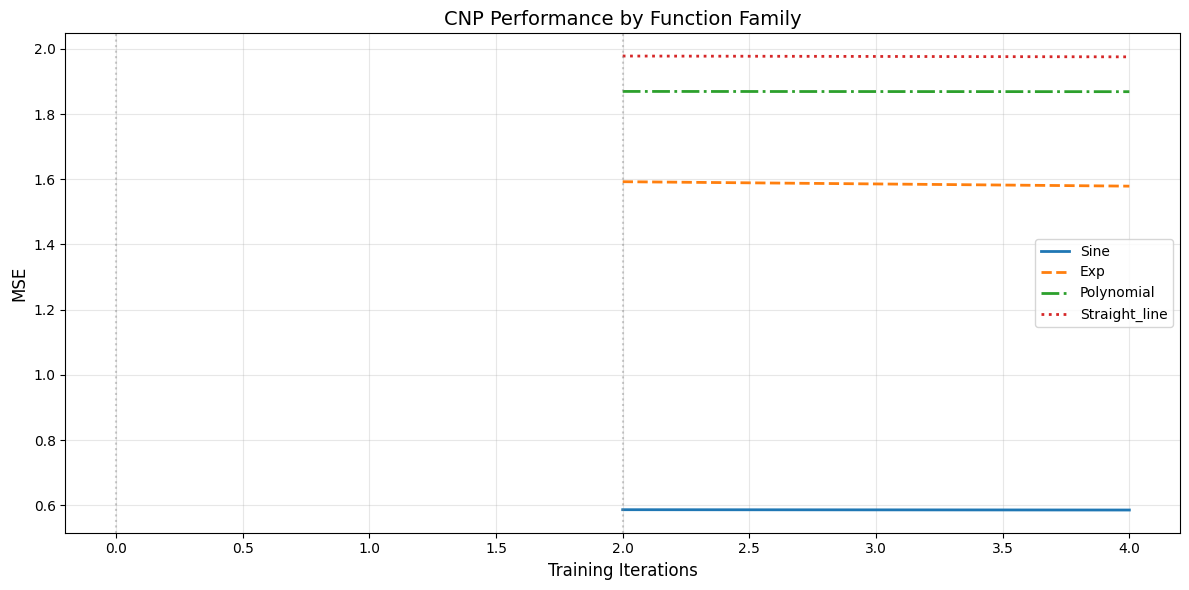

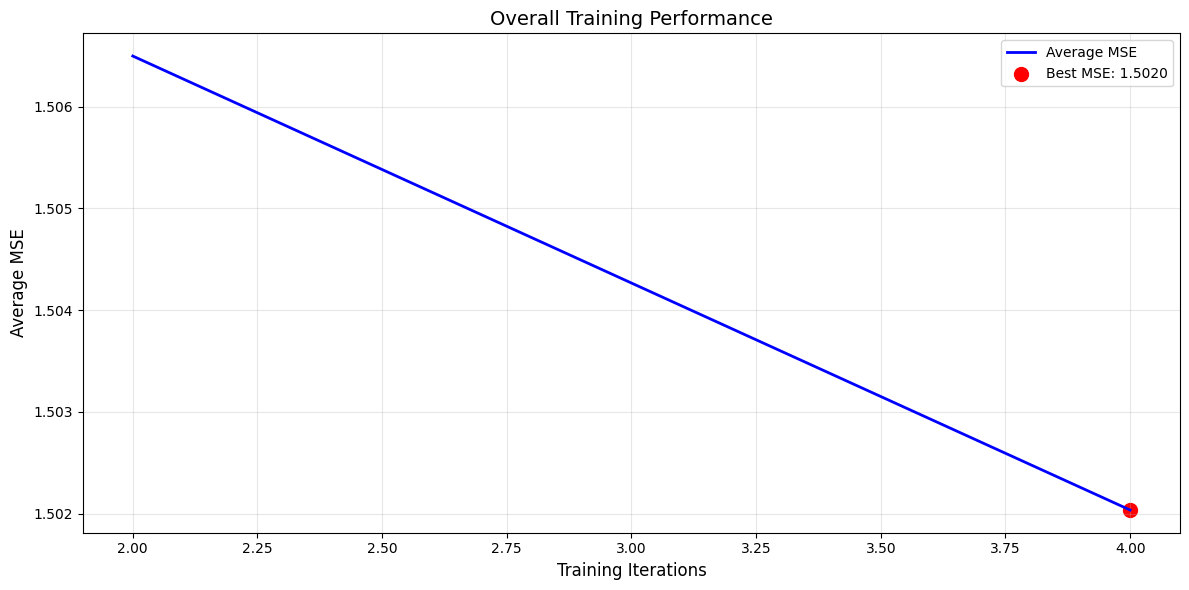


Final Evaluation and Visualization:


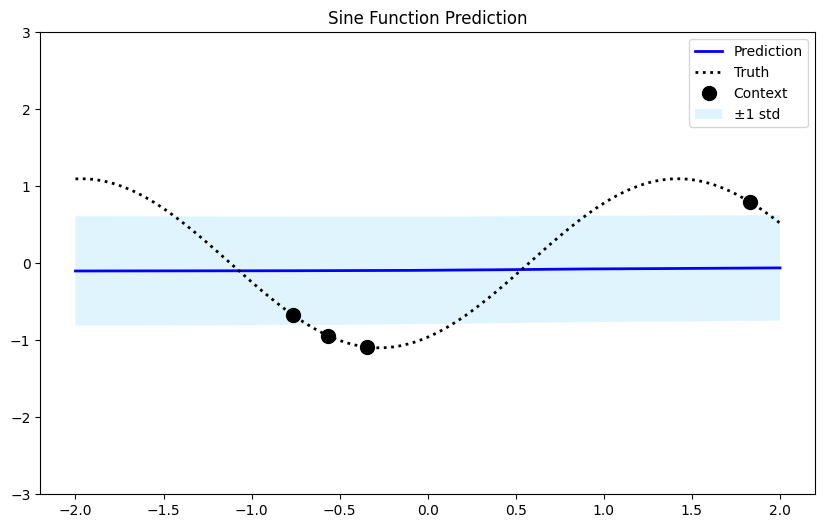

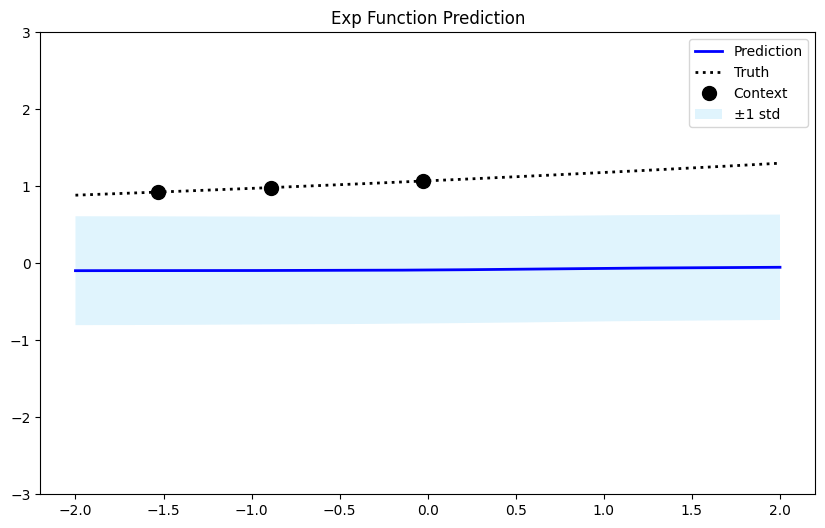

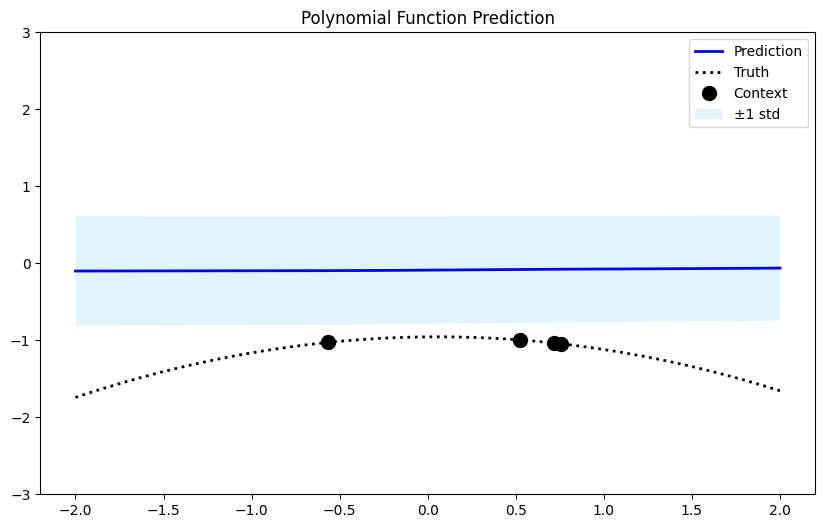

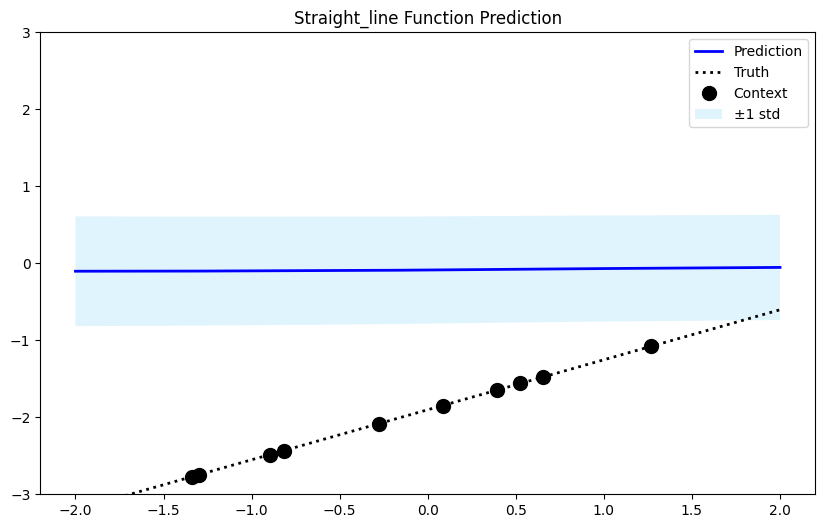

In [ ]:
# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
BLOCK_SIZE = 100
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100
# Model and Optimizer
d_x, d_in, representation_size, d_out = 1, 2, 128, 2
encoder_sizes = [d_in, 128, 128, 128, representation_size]
decoder_sizes = [representation_size + d_x, 128, 128, 2]
model = DeterministicModel(encoder_sizes, decoder_sizes)
optimizer = optim.Adam(model.parameters(), lr=1e-4)

# Training statistics
mse_values = []
training_blocks = []
family_mses = {family: [] for family in function_families}
current_family = None

def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on test datasets and returns average MSE."""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)

    if family_name is not None:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")

    return avg_mse

# Training loop with blocks
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training for {TRAINING_ITERATIONS} iterations with {BLOCK_SIZE}-iteration blocks")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

for it in range(TRAINING_ITERATIONS):
    # Switch family at the start of each block
    if it % BLOCK_SIZE == 0:
        current_family = random.choice(function_families)
        print(f"\nBlock {it // BLOCK_SIZE + 1}: Training on {current_family}")

    # Generate training batch from current family
    data_train, _ = train_reader.generate_curves(current_family)

    # Train step
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation (every EVAL_AFTER iterations)
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nEvaluation at iteration {it + 1}:")
        current_mses = {}
        total_mse = 0.0

        # Evaluate on all function families
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        # Record overall performance
        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_blocks.append(it + 1)

        print(f"Average MSE across all families: {avg_mse:.4f}")

plt.figure(figsize=(12, 6))
line_styles = ['-', '--', '-.', ':']  # Different line styles for clarity

for i, family in enumerate(function_families):
    plt.plot(training_blocks, family_mses[family],
             label=family.capitalize(),
             linestyle=line_styles[i % len(line_styles)],
             linewidth=2)

# Add vertical lines for block boundaries
for block_start in range(0, TRAINING_ITERATIONS, BLOCK_SIZE):
    if block_start < training_blocks[-1]:
        plt.axvline(block_start, color='gray', linestyle=':', alpha=0.4)

plt.xlabel('Training Iterations', fontsize=12)
plt.ylabel('MSE', fontsize=12)
plt.title('CNP Performance by Function Family', fontsize=14)
plt.legend(fontsize=10, frameon=True)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot overall training curve
plt.figure(figsize=(12, 6))
plt.plot(training_blocks, mse_values,
         color='blue', linewidth=2,
         label='Average MSE')

# Mark the best performance
best_mse = min(mse_values)
best_idx = mse_values.index(best_mse)
plt.scatter(training_blocks[best_idx], best_mse,
            color='red', s=100,
            label=f'Best MSE: {best_mse:.4f}')

plt.xlabel('Training Iterations', fontsize=12)
plt.ylabel('Average MSE', fontsize=12)
plt.title('Overall Training Performance', fontsize=14)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Final prediction plots
print("\nFinal Evaluation and Visualization:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )

Starting training at 2025-04-13 19:45:46
Training for 5 iterations with 2-iteration blocks
Training order: ['straight_line', 'polynomial', 'exp', 'sine']

Block 1: Training on straight_line

Evaluation at iteration 2 (Current family: straight_line):
  sine: MSE = 0.5848
  exp: MSE = 1.5697
  polynomial: MSE = 1.8671
  straight_line: MSE = 1.9721
Average MSE across all families: 1.4984

Block 2: Training on polynomial

Evaluation at iteration 4 (Current family: polynomial):
  sine: MSE = 0.5846
  exp: MSE = 1.5668
  polynomial: MSE = 1.8660
  straight_line: MSE = 1.9701
Average MSE across all families: 1.4969

Block 3: Training on exp


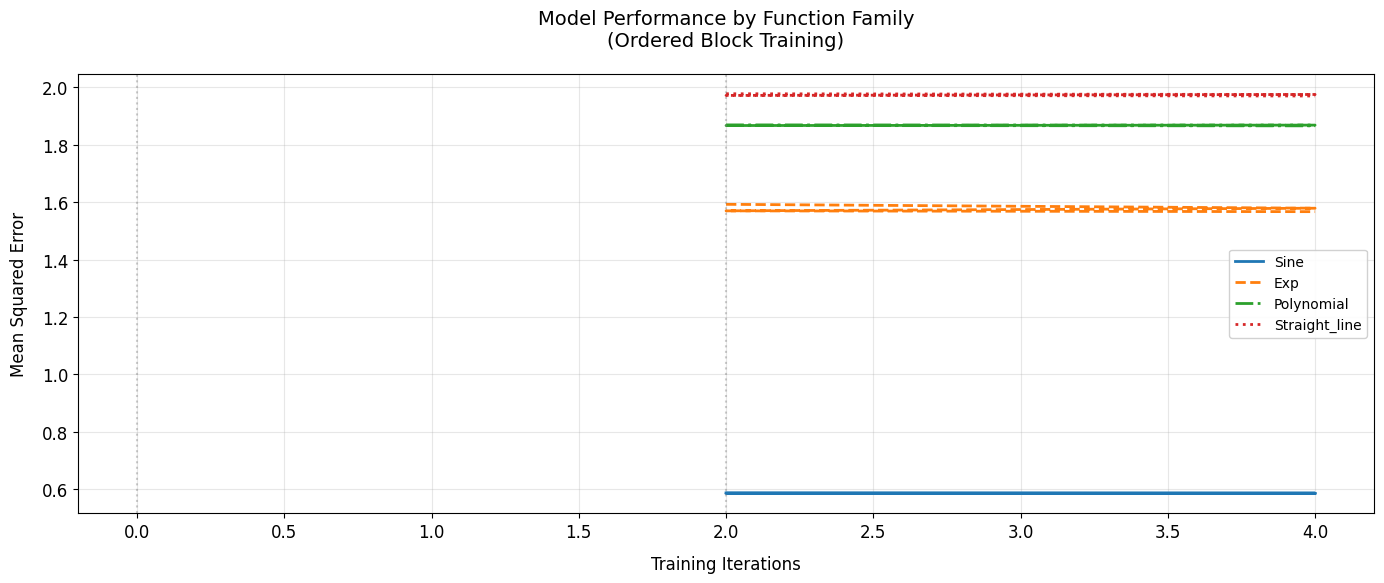

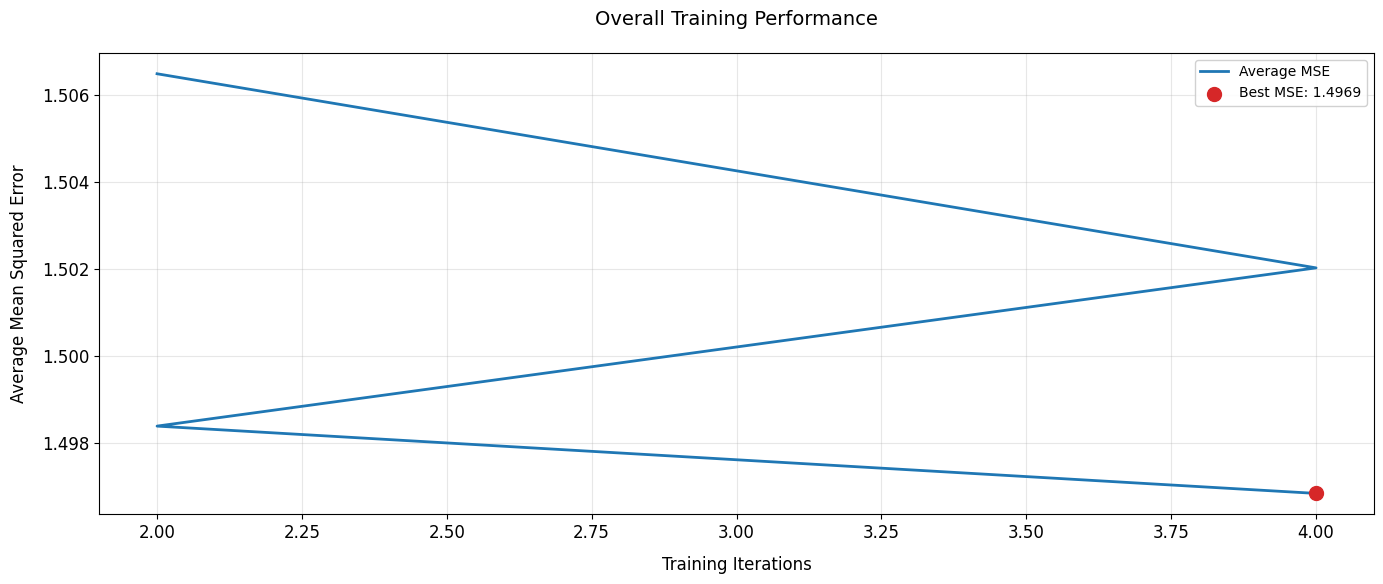


Final Evaluation:
  sine: MSE = 0.5844
sine test MSE: 0.5844


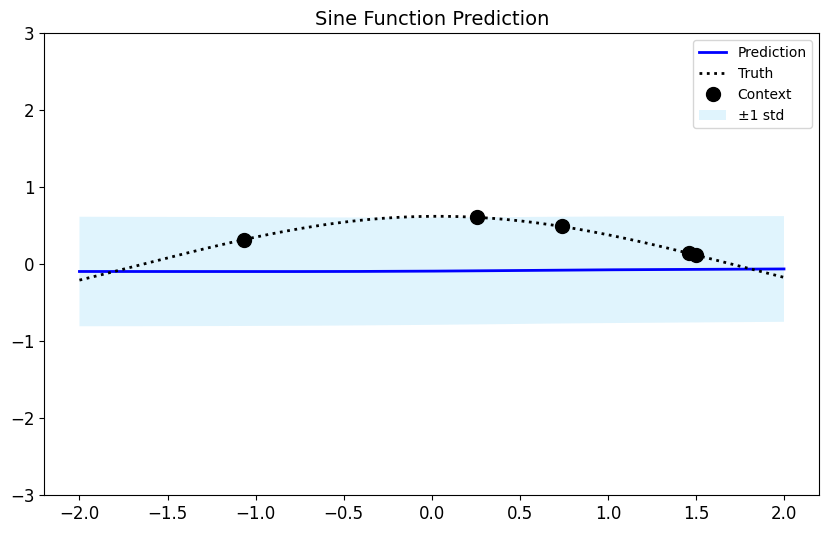

  exp: MSE = 1.5645
exp test MSE: 1.5645


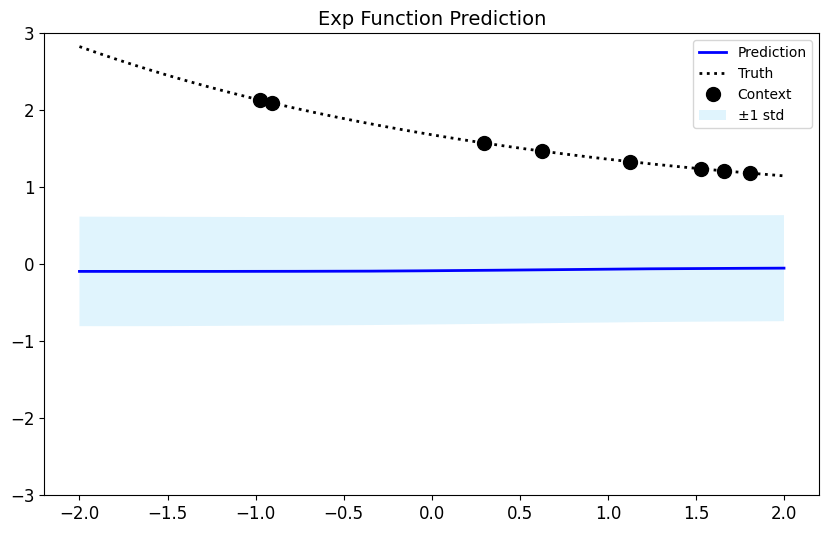

  polynomial: MSE = 1.8654
polynomial test MSE: 1.8654


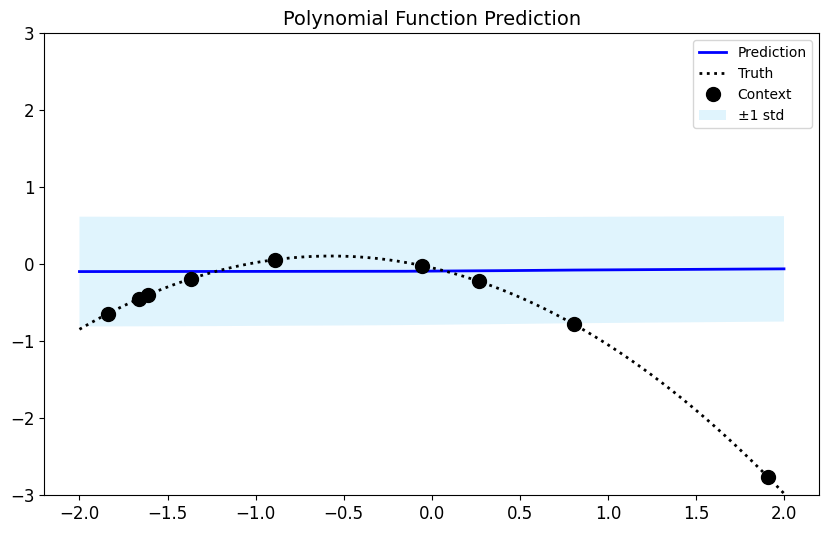

  straight_line: MSE = 1.9689
straight_line test MSE: 1.9689


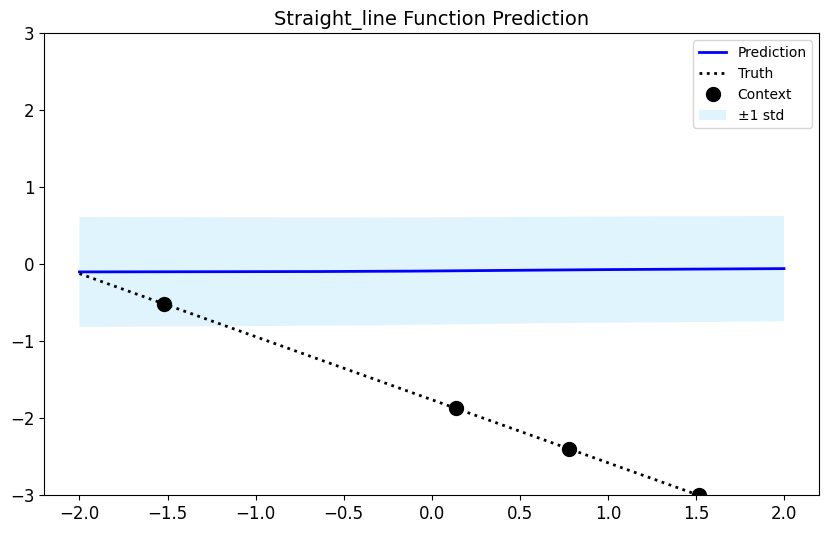

In [ ]:
# Training loop with ordered blocks
print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training for {TRAINING_ITERATIONS} iterations with {BLOCK_SIZE}-iteration blocks")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

# Define the fixed order of function families
ordered_families = [
    FunctionFamily.STRAIGHT_LINE,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.EXP,
    FunctionFamily.SINE
]
print(f"Training order: {ordered_families}")

iterations_per_cycle = len(ordered_families) * BLOCK_SIZE

for it in range(TRAINING_ITERATIONS):
    # Determine current family based on ordered cycle
    cycle_position = it % iterations_per_cycle
    family_index = cycle_position // BLOCK_SIZE
    current_family = ordered_families[family_index]

    # Print when switching families (start of each block)
    if it % BLOCK_SIZE == 0:
        print(f"\nBlock {it // BLOCK_SIZE + 1}: Training on {current_family}")

    # Generate training batch from current family
    data_train, _ = train_reader.generate_curves(current_family)

    # Train step
    optimizer.zero_grad()
    log_prob, _, _ = model(data_train.query, data_train.target_y)
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # Evaluation (every EVAL_AFTER iterations)
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nEvaluation at iteration {it + 1} (Current family: {current_family}):")
        current_mses = {}
        total_mse = 0.0

        # Evaluate on all function families
        for family in function_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family], family)
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        # Record overall performance
        avg_mse = total_mse / len(function_families)
        mse_values.append(avg_mse)
        training_blocks.append(it + 1)

        print(f"Average MSE across all families: {avg_mse:.4f}")

# Plot training curves per family with vertical lines showing family boundaries
plt.rcParams['font.size'] = 12
plt.rcParams['axes.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['legend.fontsize'] = 10

# Plot performance by function family
plt.figure(figsize=(14, 6))
# Use distinct line styles and colors
line_styles = ['-', '--', '-.', ':']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']

for i, family in enumerate(function_families):
    plt.plot(training_blocks, family_mses[family],
             label=family.capitalize(),
             linestyle=line_styles[i],
             color=colors[i],
             linewidth=2)

# Add vertical lines for family transitions
for block_start in range(0, TRAINING_ITERATIONS, BLOCK_SIZE):
    if block_start < training_blocks[-1]:
        plt.axvline(block_start, color='gray', linestyle=':', alpha=0.4)

plt.xlabel('Training Iterations', labelpad=10)
plt.ylabel('Mean Squared Error', labelpad=10)
plt.title('Model Performance by Function Family\n(Ordered Block Training)', pad=20)
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Plot overall training performance
plt.figure(figsize=(14, 6))
plt.plot(training_blocks, mse_values,
         color='#1f77b4',
         linewidth=2,
         label='Average MSE')

# Highlight the best performance
best_mse = min(mse_values)
best_idx = mse_values.index(best_mse)
plt.scatter(training_blocks[best_idx], best_mse,
            color='#d62728',
            s=100,
            zorder=5,
            label=f'Best MSE: {best_mse:.4f}')

plt.xlabel('Training Iterations', labelpad=10)
plt.ylabel('Average Mean Squared Error', labelpad=10)
plt.title('Overall Training Performance', pad=20)
plt.legend(framealpha=0.9)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Final evaluation and visualization
print("\nFinal Evaluation:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in function_families:
    # Evaluate
    test_mse = evaluate_model(model, fixed_test_datasets[family], family)
    print(f"{family} test MSE: {test_mse:.4f}")

    # Visualize
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )


Streaming output truncated to the last 5000 lines.
Test MSE per family:
  straight_line: 0.2527
  polynomial: 0.8531
  exp: 0.1001
  sine: 0.4168

Average MSE: 0.4057
Replay buffer size: 200

Block 41: Training on straight_line

Block 42: Training on polynomial

Block 43: Training on exp

Block 44: Training on sine

Block 45: Training on straight_line

Evaluation at iteration 4500 (Current family: straight_line):
Current rewards:
  straight_line: 0.9003
  polynomial: 0.6335
  exp: 0.8852
  sine: 0.6140

Test MSE per family:
  straight_line: 0.1266
  polynomial: 0.7900
  exp: 0.0801
  sine: 0.4508

Average MSE: 0.3619
Replay buffer size: 200

Block 46: Training on polynomial

Block 47: Training on exp

Block 48: Training on sine

Block 49: Training on straight_line

Block 50: Training on polynomial

Evaluation at iteration 5000 (Current family: polynomial):
Current rewards:
  straight_line: 0.9657
  polynomial: 0.9618
  exp: 0.9628
  sine: 0.6670

Test MSE per family:
  straight_line: 0

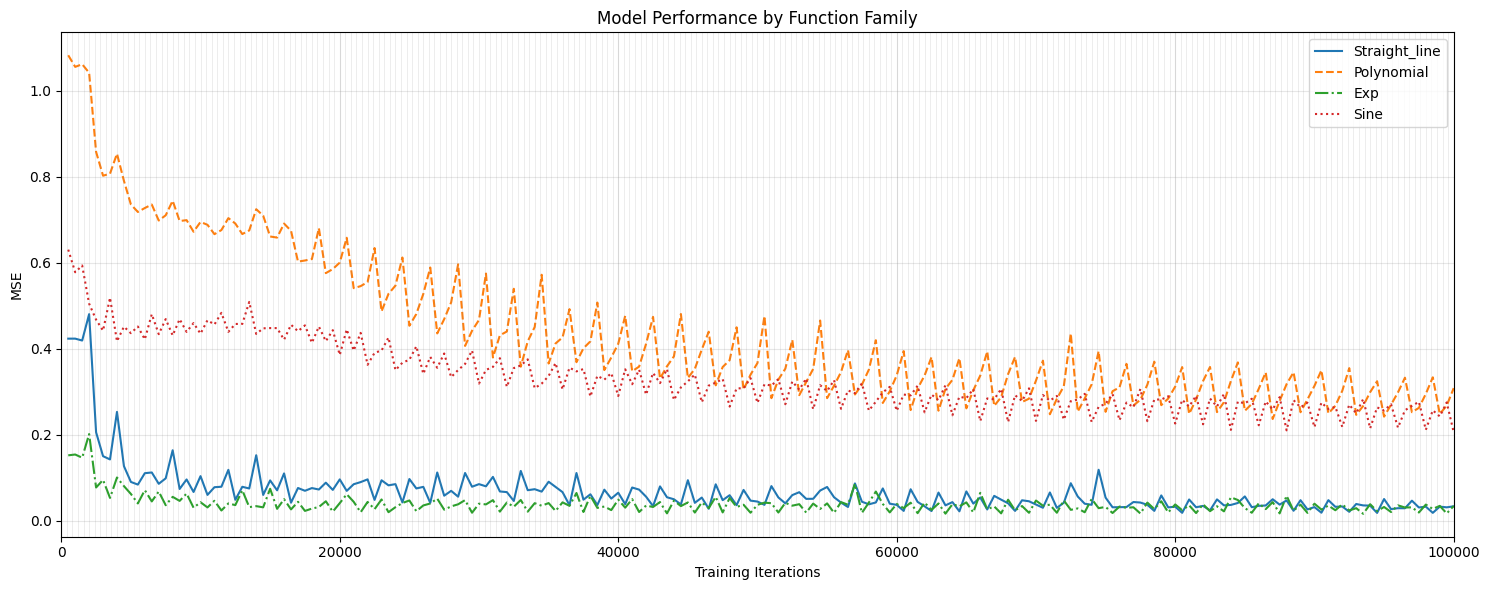


Final Evaluation:
  straight_line: MSE = 0.0332
straight_line test MSE: 0.0332


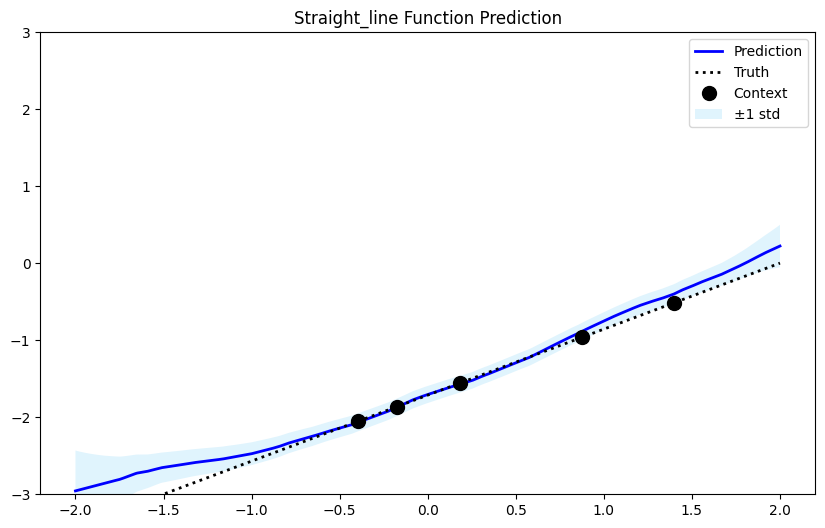

  polynomial: MSE = 0.3079
polynomial test MSE: 0.3079


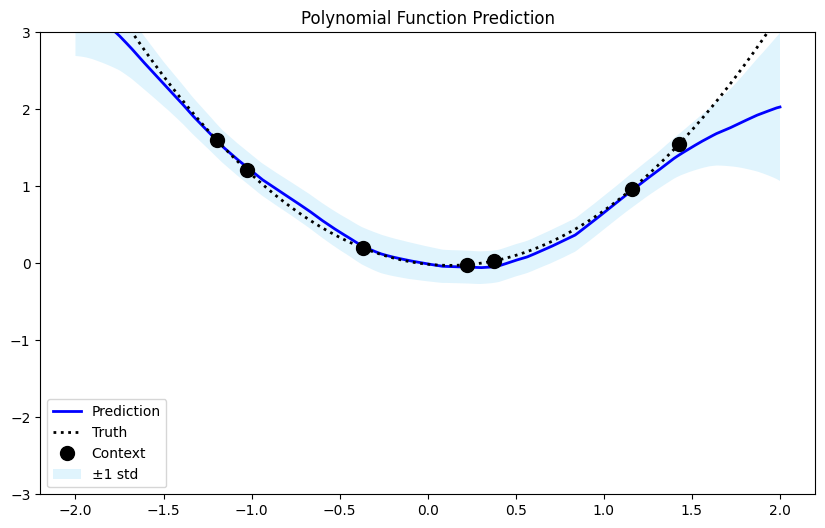

  exp: MSE = 0.0338
exp test MSE: 0.0338


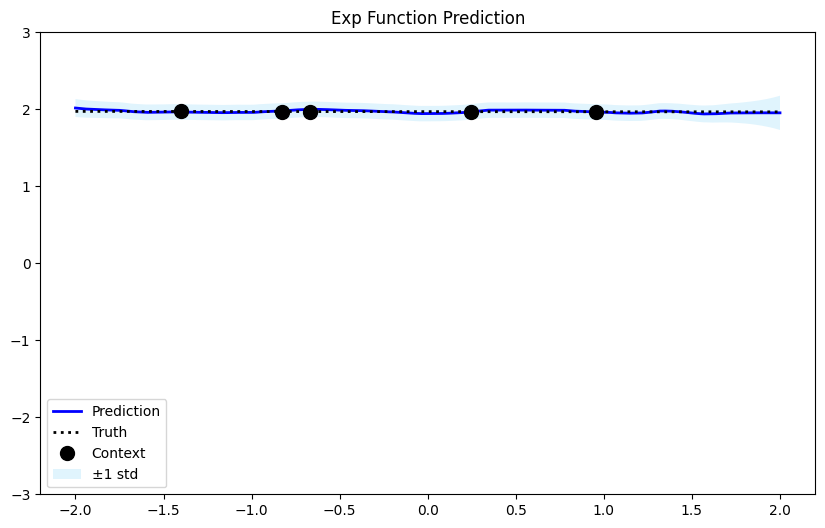

  sine: MSE = 0.2055
sine test MSE: 0.2055


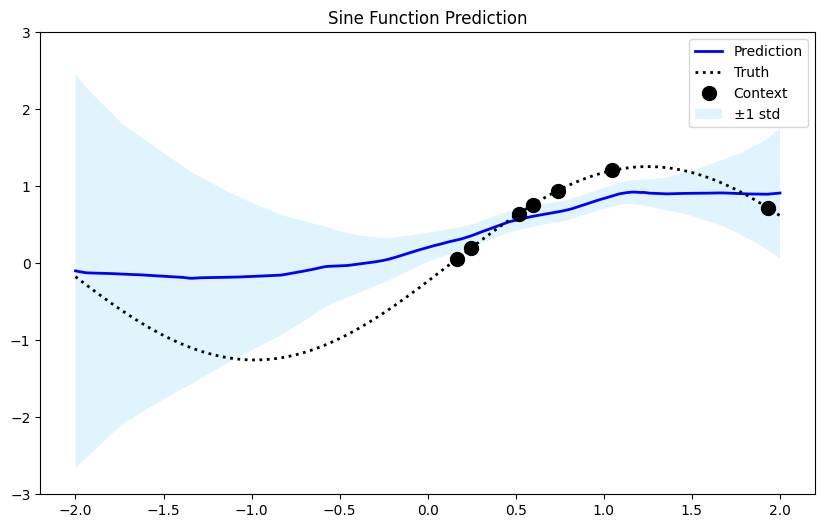

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import collections
import matplotlib.pyplot as plt
import datetime
import random
import numpy as np

class FunctionFamily:
    SINE = "sine"
    EXP = "exp"
    POLYNOMIAL = "polynomial"
    STRAIGHT_LINE = "straight_line"

function_families = [
    FunctionFamily.SINE,
    FunctionFamily.EXP,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.STRAIGHT_LINE,
]

class DeterministicEncoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicEncoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, context_x, context_y):
        encoder_input = torch.cat((context_x, context_y), dim=-1)
        batch_size, set_size, filter_size = encoder_input.shape
        x = encoder_input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        x = x.view(batch_size, set_size, -1)
        representation = x.mean(dim=1)
        return representation

class DeterministicDecoder(nn.Module):
    def __init__(self, sizes):
        super(DeterministicDecoder, self).__init__()
        self.linears = nn.ModuleList()
        for i in range(len(sizes) - 1):
            self.linears.append(nn.Linear(sizes[i], sizes[i + 1]))

    def forward(self, representation, target_x):
        batch_size, set_size, d = target_x.shape
        representation = representation.unsqueeze(1).repeat([1, set_size, 1])
        input = torch.cat((representation, target_x), dim=-1)
        x = input.view(batch_size * set_size, -1)
        for i, linear in enumerate(self.linears[:-1]):
            x = torch.relu(linear(x))
        x = self.linears[-1](x)
        out = x.view(batch_size, set_size, -1)
        mu, log_sigma = torch.split(out, 1, dim=-1)
        sigma = 0.1 + 0.9 * torch.nn.functional.softplus(log_sigma)
        dist = torch.distributions.normal.Normal(loc=mu, scale=sigma)
        return dist, mu, sigma

class DeterministicModel(nn.Module):
    def __init__(self, encoder_sizes, decoder_sizes):
        super(DeterministicModel, self).__init__()
        self._encoder = DeterministicEncoder(encoder_sizes)
        self._decoder = DeterministicDecoder(decoder_sizes)

    def forward(self, query, target_y=None):
        (context_x, context_y), target_x = query
        representation = self._encoder(context_x, context_y)
        dist, mu, sigma = self._decoder(representation, target_x)
        log_p = None if target_y is None else dist.log_prob(target_y)
        return log_p, mu, sigma

def plot_functions(target_x, target_y, context_x, context_y, pred_y, var, title=""):
    """Plots the predicted mean and variance and the context points."""
    plt.figure(figsize=(10, 6))
    plt.plot(target_x[0].squeeze(), pred_y[0].squeeze(), "b", linewidth=2, label='Prediction')
    plt.plot(target_x[0].squeeze(), target_y[0].squeeze(), "k:", linewidth=2, label='Truth')
    plt.plot(context_x[0].squeeze(), context_y[0].squeeze(), "ko", markersize=10, label='Context')
    plt.fill_between(
        target_x[0].squeeze(),
        (pred_y[0] - var[0]).squeeze(),
        (pred_y[0] + var[0]).squeeze(),
        alpha=0.2,
        facecolor="#65c9f7",
        interpolate=True,
        label='±1 std'
    )
    plt.legend()
    plt.ylim([-3, 3])
    plt.title(title)
    plt.show()

class FixedReplayBuffer:
    def __init__(self, capacity):
        self.capacity = capacity
        self.buffer = []
        self.position = 0

    def push(self, experience):
        if len(self.buffer) < self.capacity:
            self.buffer.append(experience)
        else:
            self.buffer[self.position] = experience
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.buffer, min(batch_size, len(self.buffer)))

    def __len__(self):
        return len(self.buffer)
def evaluate_model(model, test_datasets, family_name=None):
    """Evaluates the model on fixed test datasets"""
    model.eval()
    total_mse = 0.0
    with torch.no_grad():
        for data_test in test_datasets:
            _, pred_y, _ = model(data_test.query, data_test.target_y)
            mse = torch.mean((pred_y - data_test.target_y)**2)
            total_mse += mse.item()
    model.train()
    avg_mse = total_mse / len(test_datasets)
    if family_name:
        print(f"  {family_name}: MSE = {avg_mse:.4f}")
    return avg_mse
# Hyperparameters
TRAINING_ITERATIONS = int(1e5)
BLOCK_SIZE = 100
EVAL_AFTER = 500
MAX_CONTEXT_POINTS = 10
BATCH_SIZE = 64
TEST_BATCH_SIZE = 100
NUM_TEST_TASKS = 100
REPLAY_BUFFER_SIZE = 200
RL_REPLAY_BATCH = 64
RL_UPDATE_FREQ = 20

# Define the fixed order of function families
ordered_families = [
    FunctionFamily.STRAIGHT_LINE,
    FunctionFamily.POLYNOMIAL,
    FunctionFamily.EXP,
    FunctionFamily.SINE
]


# Model and Optimizer
model = DeterministicModel(
    [2, 128, 128, 128, 128],
    [128 + 1, 128, 128, 2]
)
optimizer = optim.Adam(model.parameters(), lr=1e-4)
replay_buffer = FixedReplayBuffer(REPLAY_BUFFER_SIZE)

# Training statistics
mse_values = []
training_blocks = []
family_mses = {fam: [] for fam in function_families}
current_rewards = {fam: 0 for fam in function_families}
rl_rewards = {fam: 0 for fam in function_families}

print(f"Starting training at {datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print(f"Training for {TRAINING_ITERATIONS} iterations with {BLOCK_SIZE}-iteration blocks")
print(f"Training order: {ordered_families}")

train_reader = CurvesReader(BATCH_SIZE, MAX_CONTEXT_POINTS, testing=False)

for it in range(TRAINING_ITERATIONS):
    # Determine current family based on ordered cycle
    cycle_position = it % (len(ordered_families) * BLOCK_SIZE)
    family_index = cycle_position // BLOCK_SIZE
    current_family = ordered_families[family_index]

    # Print when switching families (start of each block)
    if it % BLOCK_SIZE == 0:
        print(f"\nBlock {it // BLOCK_SIZE + 1}: Training on {current_family}")

    # Training step
    data_train, _ = train_reader.generate_curves(current_family)
    log_prob, pred_y, _ = model(data_train.query, data_train.target_y)

    # Calculate and store reward
    with torch.no_grad():
        error = torch.mean((pred_y - data_train.target_y)**2).item()
        reward = 1.0 / (1.0 + error)
        current_rewards[current_family] = reward

    # Store in replay buffer
    replay_buffer.push((data_train.query, data_train.target_y, current_family))

    optimizer.zero_grad()
    loss = -log_prob.mean()
    loss.backward()
    optimizer.step()

    # RL update from shared buffer
    if it % RL_UPDATE_FREQ == 0 and len(replay_buffer) > RL_REPLAY_BATCH:
        batch = replay_buffer.sample(RL_REPLAY_BATCH)
        queries, target_ys, families = zip(*batch)

        log_probs = []
        new_rewards = []

        for query, target_y, family in zip(queries, target_ys, families):
            log_prob, pred_y, _ = model(query, target_y)
            log_probs.append(log_prob.mean())

            with torch.no_grad():
                error = torch.mean((pred_y - target_y)**2).item()
                reward = 1.0 / (1.0 + error)
                new_rewards.append(reward)
                rl_rewards[family] = reward

        loss = -torch.mean(torch.stack(log_probs))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    # Evaluation
    if (it + 1) % EVAL_AFTER == 0:
        print(f"\nEvaluation at iteration {it + 1} (Current family: {current_family}):")
        print("Current rewards:")
        for fam in ordered_families:
            print(f"  {fam}: {current_rewards[fam]:.4f}")

        if it % RL_UPDATE_FREQ == 0:
            print("\nRL batch rewards:")
            for fam in ordered_families:
                print(f"  {fam}: {rl_rewards[fam]:.4f}")

        # Evaluation on test sets
        current_mses = {}
        total_mse = 0.0
        for family in ordered_families:
            family_mse = evaluate_model(model, fixed_test_datasets[family])
            current_mses[family] = family_mse
            family_mses[family].append(family_mse)
            total_mse += family_mse

        avg_mse = total_mse / len(ordered_families)
        mse_values.append(avg_mse)
        training_blocks.append(it + 1)

        print("\nTest MSE per family:")
        for family, mse in current_mses.items():
            print(f"  {family}: {mse:.4f}")

        print(f"\nAverage MSE: {avg_mse:.4f}")
        print(f"Replay buffer size: {len(replay_buffer)}")

plt.figure(figsize=(15, 6))

# Plot MSE curves
line_styles = ['-', '--', '-.', ':']
for i, family in enumerate(ordered_families):
    plt.plot(training_blocks, family_mses[family],
             label=family.capitalize(),
             linestyle=line_styles[i % len(line_styles)],
             linewidth=1.5)

# Add subtle block transition markers
for block_start in range(0, TRAINING_ITERATIONS, BLOCK_SIZE):
    if block_start % (len(ordered_families)*BLOCK_SIZE) == 0:  # Only full cycles
        plt.axvline(block_start, color='gray', alpha=0.2, linewidth=0.5)

# Configure axes
plt.xlim(0, TRAINING_ITERATIONS)
if max(mse_values)/min(mse_values) > 100:
    plt.yscale('log')
    plt.ylabel('Log MSE')
else:
    plt.ylabel('MSE')

plt.xlabel('Training Iterations')
plt.title('Model Performance by Function Family')
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()
# Final evaluation and visualization
print("\nFinal Evaluation:")
test_reader = CurvesReader(1, MAX_CONTEXT_POINTS, testing=True)
for family in ordered_families:
    # Evaluate
    test_mse = evaluate_model(model, fixed_test_datasets[family], family)
    print(f"{family} test MSE: {test_mse:.4f}")

    # Visualize
    data_test, _ = test_reader.generate_curves(family)
    with torch.no_grad():
        _, pred_y, var = model(data_test.query, data_test.target_y)
        (context_x, context_y), target_x = data_test.query
        plot_functions(
            target_x.detach().numpy(),
            data_test.target_y.detach().numpy(),
            context_x.detach().numpy(),
            context_y.detach().numpy(),
            pred_y.detach().numpy(),
            var.detach().numpy(),
            title=f"{family.capitalize()} Function Prediction"
        )